In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import os
import polars as pl

# 市场规律统计

In [4]:
def structure_stats(fret, *states):
    state_frets = []
    counts = []; wgts = []; winrates = []; odds = []; kelly = []; avgrets = []; avgstds = []; avgsps = []
    for state in states:
        state_frets.append(eval("fret[state]"))
    for sf in state_frets:
        counts.append(len(sf))
        wgts.append('{:.2%}'.format(len(sf)/len(fret)))
        avgrets.append('{:.4%}'.format(sf.mean()))
        if sf.mean()>0:
            odd = -sf[sf>0].mean()/sf[sf<0].mean()
            winr = (sf>0).mean()
        else:
            odd = -sf[sf<0].mean()/sf[sf>0].mean()
            winr = (sf<0).mean()
        winrates.append('{:.2%}'.format(winr))
        odds.append('{:.4f}'.format(odd))
        kelly.append('{:.4f}'.format(winr*odd-(1-winr)))
        avgstds.append('{:.2%}'.format(sf.std()))
        avgsps.append('{:.2f}'.format(np.abs(sf.mean()/sf.std())))
    print(pd.DataFrame({'count': counts, 'wgt': wgts, 'avgret': avgrets, 'avgstd': avgstds, 'winr': winrates, 'odd': odds, 'kelly': kelly, 'avg sp': avgsps}, index=np.arange(1, len(states)+1)))

def annual_stat(fret, state):
    df = pd.DataFrame({'fret': fret[state]})
    ann_num = pd.DataFrame({'fret': fret, 'year': fret.index.str[:4]}).groupby('year')['fret'].count()
    df['year'] = df.index.str[:4]
    group = df.groupby('year')['fret']
    count = group.count()
    wgt = count / ann_num
    avgret = group.mean()
    avgstd = group.std()
    if df['fret'].mean()>0:
        winr = group.apply(lambda x: (x>0).mean())
        odd = group.apply(lambda x: -x[x>0].mean()/x[x<0].mean())
    else:
        winr = group.apply(lambda x: (x<0).mean())
        odd = group.apply(lambda x: -x[x<0].mean()/x[x>0].mean())
    kelly = winr*odd - (1-winr)
    avgsp = avgret/avgstd
    wgt = wgt.map(lambda x: '{:.2%}'.format(x))
    avgret = avgret.map(lambda x: '{:.4%}'.format(x))
    avgstd = avgstd.map(lambda x: '{:.2%}'.format(x))
    winr = winr.map(lambda x: '{:.2%}'.format(x))
    odd = odd.map(lambda x: '{:.4f}'.format(x))
    kelly = kelly.map(lambda x: '{:.2f}'.format(x))
    avgsp = avgsp.map(lambda x: '{:.2f}'.format(x))
    print(pd.DataFrame({'count': count, 'wgt': wgt, 'avgret': avgret, 'avgstd': avgstd, 'winr': winr, 'odd': odd, 'kelly': kelly, 'avg sp': avgsp}))

In [103]:
df = pd.read_pickle('./data/zz1000.pkl')
df = df.loc[(df.index<='20221231')&(df.index>='20180101')]
# df = df.loc[df.index<='20221231']
day = 1
fret = df['open'].pct_change(day).shift(-day-1)
r1 = ((df['high']-df['open'])/(df['high']-df['low'])).rolling(5).mean()
r2 = ((df['close']-df['low'])/(df['high']-df['low'])).rolling(5).mean()
diff = r1 - r2
f1 = (df['close']-df['open']).shift(1)
f2 = (df['close']-df['open'])
# f2 = (df['close']-df['low'])/(df['high']-df['low'])
f3 = df['volume'].rolling(5).rank()
state1 = (diff>0)
state2 = (diff<0)
state3 = (f1<0)&(f2>0)
state4 = (f1>0)&(f2<0)
# state3 = (r1<0.5)&(r2<0.5)&(f1>=0)
# state4 = (r1<0.5)&(r2<0.5)&(f1<0)
structure_stats(fret, *(state1, state2, state3, state4))
annual_stat(fret, state3)
annual_stat(fret, state4)

   count     wgt    avgret avgstd    winr     odd   kelly avg sp
1    400  32.92%   0.1783%  1.54%  57.25%  1.0057  0.1483   0.12
2    811  66.75%  -0.0853%  1.61%  49.94%  1.1538  0.0756   0.05
3    308  25.35%  -0.0632%  1.68%  50.65%  1.0698  0.0483   0.04
4    309  25.43%   0.0452%  1.57%  52.75%  0.9596  0.0337   0.03
      count     wgt    avgret avgstd    winr     odd  kelly avg sp
year                                                              
2018     60  24.69%  -0.1658%  1.41%  56.67%  1.0462   0.16  -0.12
2019     63  25.82%   0.0136%  1.65%  49.21%  1.0107  -0.01   0.01
2020     69  28.40%  -0.0919%  2.23%  52.17%  1.0380   0.06  -0.04
2021     58  23.87%   0.1584%  1.33%  41.38%  1.0581  -0.15   0.12
2022     57  23.75%  -0.2309%  1.56%  53.45%  1.1817   0.17  -0.15
      count     wgt    avgret avgstd    winr     odd  kelly avg sp
year                                                              
2018     60  24.69%  -0.2783%  1.63%  41.67%  0.9001  -0.21  -0.17
2019 

In [37]:
pd.read_pickle('./dump/stocktiming4.pkl').kurt(0).mean()
# pd.read_pickle('./data/sz50.pkl')

-1.6612928521929646

# 不同策略对比

## 1.1 因子/策略相关性测试

In [39]:
check_id = 'stocktiming5'
basic = pd.read_pickle(f'./pnl/{check_id}.pnl.pkl')
for pnl_id in os.listdir('./pnl'):
    if 'stocktiming' in pnl_id:
        if check_id not in pnl_id:
            pnl = pd.read_pickle(f'./pnl/{pnl_id}')
            print(f'{pnl_id[:-8]}: {pnl.corr(basic):.4f}')

stocktiming1: 0.6273
stocktiming2: 0.2661
stocktiming3: -0.1251
stocktiming4: -0.1378


## 1.2 策略曲线对比

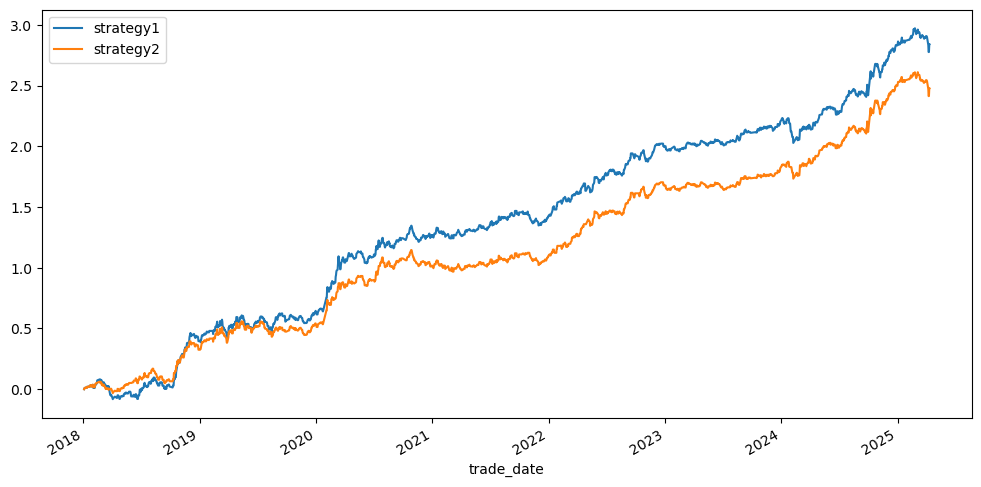

In [ ]:
nav1 = pd.read_pickle('./pnl/timing1_v1.pnl.pkl').cumsum()
nav1.index = pd.to_datetime(nav1.index)
nav2 = pd.read_pickle('./pnl/timing1.pnl.pkl').cumsum()
nav2.index = pd.to_datetime(nav2.index)
ax = nav1.plot(label='strategy1')
ax.plot(nav2, label='strategy2')
ax.legend()

# 交易对胜率提升

In [ ]:
# df = pd.read_pickle('./data/[v2交易对stk]无强制闭环_20241207.pkl')
# df = df[df.factor_date>=pd.to_datetime('20200101')].reset_index(drop=True)

alpha = pd.read_pickle('./dump/alpha5_v1.pkl')
alpha.index = pd.to_datetime(alpha.index)
alpha = alpha.rank(axis=1, method='dense', pct=True)
alpha_ts = alpha.stack().reset_index()
alpha_ts.columns = ['factor_date', 'code', 'alpha']

df1 = df.merge(alpha_ts, on=['code', 'factor_date'], how='left')
# low = (df1.loc[df1['alpha']<0.33, 'return']>0).mean()
low = len(df1.loc[df1['alpha']<0.33, 'return'])/len(df1)
# med = (df1.loc[(df1['alpha']>=0.33)&(df1['alpha']<0.67), 'return']>0).mean()
med = len(df1.loc[(df1['alpha']>=0.33)&(df1['alpha']<0.67), 'return'])/len(df1)
# high = (df1.loc[df1['alpha']>=0.67, 'return']>0).mean()
high = len(df1.loc[df1['alpha']>=0.67, 'return'])/len(df1)
# print(low, med, high)

df1['year'] = df1['factor_date'].dt.year
gpdf = df1.groupby('year')[['alpha', 'return']]
# glow = gpdf.apply(lambda x: (x.loc[x['alpha']<0.33, 'return']>0).mean())
glow = gpdf.apply(lambda x: len(x.loc[x['alpha']<0.33, 'return'])/len(x))
# gmed = gpdf.apply(lambda x: (x.loc[(x['alpha']>=0.33)&(x['alpha']<0.67), 'return']>0).mean())
gmed = gpdf.apply(lambda x: len(x.loc[(x['alpha']>=0.33)&(x['alpha']<0.67), 'return'])/len(x))
# ghigh = gpdf.apply(lambda x: (x.loc[x['alpha']>=0.67, 'return']>0).mean())
ghigh = gpdf.apply(lambda x: len(x.loc[x['alpha']>=0.67, 'return'])/len(x))
winr = pd.concat([glow, gmed, ghigh], axis=1)
winr.loc['total'] = [low, med, high]
winr

,0,1,2
year,,,
2020,0.322534,0.326782,0.333905
2021,0.304893,0.321943,0.345101
2022,0.312623,0.326590,0.331028
2023,0.304770,0.327519,0.346681
2024,0.309977,0.330352,0.342939
total,0.310492,0.326881,0.340164


In [112]:
import polars as pl
for file in os.listdir('./stock_mbar'):
    if 'ashare' in file:
        df = pl.read_parquet(f'./stock_mbar/{file}').filter(~pl.col('code').str.contains('NQ'))
        df.write_parquet(f'./stock_mbar/{file}')

In [5]:
calendar = pd.read_pickle('./data/calendar.pkl')
calendar = calendar[calendar>='20250501']
factor = []
for date in calendar:
    df = pl.scan_parquet(f'./stock_mbar/ashare_{date}.parquet')
    df = df.group_by('code').agg(pl.col('open').cast(pl.Float64).std().alias('factor')).with_columns(pl.lit(date).alias('date'))
    factor.append(df.collect())
pl.concat(factor).pivot(on='code', index='date', values='factor').to_pandas()

,date,603359.SH,001306.SZ,300789.SZ,003039.SZ,300589.SZ,600850.SH,605098.SH,600094.SH,603938.SH,...,300507.SZ,300185.SZ,299858.SZ,002828.SZ,140001.SZ,140002.SZ,299859.SZ,688621.SH,688755.SH,301636.SZ
0,20250506,0.341502,1.226284,0.116013,0.034623,0.039040,0.078180,0.119244,0.015681,0.036807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20250507,0.150174,1.119719,0.253221,0.055645,0.083609,0.109454,0.234980,0.025982,0.151972,...,0.043881,0.023034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20250508,0.049330,0.661048,0.181826,0.035814,0.104571,0.158722,0.186304,0.008448,0.110193,...,0.231958,0.015822,2.787089,0.159194,NaN,NaN,NaN,NaN,NaN,NaN
3,20250509,0.056648,0.818610,0.144306,0.044415,0.055369,0.111584,0.158090,0.016812,0.116625,...,0.119270,0.017128,4.408108,0.045460,NaN,NaN,NaN,NaN,NaN,NaN
4,20250512,0.028289,0.408837,0.169829,0.070531,0.129403,0.092479,0.100561,0.006764,0.076014,...,0.159746,0.015018,2.550750,0.023074,NaN,NaN,NaN,NaN,NaN,NaN
5,20250513,0.045042,0.526561,0.242182,0.065898,0.094580,0.163707,0.136177,0.013131,0.084581,...,0.082996,0.017757,3.297109,0.030354,NaN,NaN,0.297270,0.693917,NaN,NaN
6,20250514,0.136138,0.580333,0.214195,0.054800,0.046852,0.088190,0.131970,0.016898,0.185728,...,0.047206,0.008493,1.820550,0.044016,NaN,NaN,0.405943,0.526597,NaN,NaN
7,20250515,0.120239,0.418680,0.119091,0.033540,0.067389,0.118842,0.135921,0.011465,0.164017,...,0.054424,0.017970,1.511695,0.051142,NaN,NaN,0.819343,0.320379,NaN,NaN
8,20250516,0.189358,0.496474,0.097490,0.034670,0.083482,0.057140,0.339081,0.009122,0.049305,...,0.042797,0.008493,1.117393,0.018466,NaN,NaN,0.683003,0.935349,1.393243,1.972518


In [56]:
pd.read_pickle('./dump/stocktiming5.pkl').iloc[-120:, 50:100]

code,600623.SH,000504.SZ,000505.SZ,600624.SH,600625.SH,600626.SH,600627.SH,600628.SH,600629.SH,600630.SH,...,000026.SZ,600650.SH,000024.SZ,600660.SH,600662.SH,600661.SH,000025.SZ,600663.SH,600664.SH,600665.SH
date,,,,,,,,,,,,,,,,,,,,,
20241115,0.900346,-0.847316,-0.514095,-0.084247,NaN,-0.109146,NaN,1.000000,1.000000,-0.024067,...,-0.378498,1.000000,NaN,-0.576718,-0.435442,-0.428110,0.072106,-0.987981,0.592176,-0.112524
20241118,1.000000,-1.000000,-0.167822,-0.041697,NaN,-0.301068,NaN,1.000000,1.000000,0.268311,...,0.192009,1.000000,NaN,-0.333371,-0.097330,-0.298157,0.519510,-0.467122,0.660840,0.116284
20241119,1.000000,-1.000000,-0.532526,-0.099946,NaN,-0.871755,NaN,1.000000,1.000000,-0.002087,...,-0.089697,1.000000,NaN,-1.000000,-0.268774,-0.895809,0.385148,-0.466509,0.100636,0.314363
20241120,1.000000,-1.000000,-0.671869,-0.045227,NaN,-1.000000,NaN,0.815012,1.000000,-0.317016,...,-0.304452,1.000000,NaN,-1.000000,-0.503666,-1.000000,-0.059878,-0.450156,-0.617750,0.083008
20241121,0.647331,1.000000,-0.277266,0.001869,NaN,-1.000000,NaN,0.265286,0.520181,-0.673703,...,-0.738584,1.000000,NaN,-1.000000,-1.000000,-1.000000,-0.426491,-0.723476,-1.000000,-0.085784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20250512,0.336409,NaN,-0.850708,0.458081,NaN,-0.787852,NaN,-1.000000,-1.000000,-0.078980,...,1.000000,0.604047,NaN,-0.893174,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
20250513,0.564796,NaN,-0.753698,0.348120,NaN,-0.217638,NaN,-1.000000,-1.000000,0.261322,...,1.000000,0.742956,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-0.640422,-0.402828,-1.000000
20250514,-0.041725,NaN,-0.849395,0.389602,NaN,-0.245718,NaN,-1.000000,-1.000000,0.482078,...,1.000000,0.155822,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-0.279077,-0.326376,-1.000000


In [10]:
pd.read_pickle('./models/pred_stockridge.pkl')
# pd.read_pickle('./dump/stockridge.pkl')

code,000004.SZ,000005.SZ,600653.SH,600652.SH,600602.SH,600601.SH,600656.SH,600654.SH,600651.SH,000002.SZ,...,301662.SZ,001400.SZ,603202.SH,301560.SZ,920068.BJ,301636.SZ,688755.SH,301595.SZ,603014.SH,001390.SZ
date_id,,,,,,,,,,,,,,,,,,,,,
20170710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20250526,NaN,NaN,-0.000586,NaN,-0.000670,-0.000011,NaN,-0.001623,0.000509,-0.000322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20250527,NaN,NaN,-0.003477,NaN,-0.003091,-0.002079,NaN,-0.004134,-0.003126,-0.001330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20250528,NaN,NaN,-0.002287,NaN,-0.003425,-0.003084,NaN,-0.002172,-0.001912,-0.001966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
